# 1. Introduction

Gig workers are independent contractors. They are not in a fixed long-term relationship with the organization and they have the ability to set their own hours and move between different platforms easily. Hence, it is important to assess the daily and hourly activity of these drivers, to have an assurance of driver supply and availability in the near future. A year, month or day ahead forecast can help the utilities plan for a larger time scale but for smoother daily operations an hourly (or even better) forecast can prove very useful.

This project will involve analyzing activity of drivers with atleast ~ 2 years of history with the spark app to find trends in *Spark On* minutes spent around hour of the day, day of the week, season of the year etc. and also to check factors like hiked delivery fees and offer frequency that can impact the driver's willingness to go online. A model can be built to predict the time spent online with given parameters like day of week, time of day etc, season, holiday etc.

In [35]:
#importing all the required libraries and modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
from google.cloud import bigquery
plt.style.use('bmh')

# 2. Data

The table I extracted data from is a join between DRVR_APPLN_ACTV and DRVR. For the purpose of this project, I will be using data pertaining to only the Orlando region (has much data and diverse drivers) to study driver activity. To start off, we will be looking at a univariate analysis of minutes spent online during every hour for the past 2 years and then move on to a multivariate analysis on how other factors could be influencing the drivers. The most important attributes we require are DRVR_USER_ID, DRVR_ACTV_IND, ACTV_START_TS, ACTL_ACTV_END_TS, **ACTV_DUR_MIN_QTY**. The given data is a collection of irregular activity timestamps that are scattered randomly between minutes, hours and days. But for our project, we need a uniform timeline of every hour in the selected period of time and the value of number of minutes spent online during each of these slot hours.

In [36]:
#connecting notebook to gcloud bigquery to query data.
cred_file = r"C:\Users\V0V01S7\AppData\Roaming\gcloud\legacy_credentials\venkatasaiyashaswi.v@walmart.com\adc.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_file
def query_bq(QUERY):
    client = bigquery.Client(project='wmt-edw-sandbox')
    query_job = client.query(QUERY) # API request
    rows = query_job.result() # Waits for query to finish
    df = rows.to_dataframe()
    return df

In [37]:
code = """select A.DRVR_USER_ID, 
B.ACTV_START_TS, B.ACTL_ACTV_END_TS, B.ACTV_DUR_MIN_QTY, B.ACTV_DT, 
from `wmt-edw-prod.WW_GEC_VM.DRVR` A inner join `wmt-edw-prod.WW_GEC_VM.DRVR_APPLN_ACTV` B on A.DRVR_USER_ID = B.DRVR_USER_ID
where A.MARKET_NM = 'Walmart Orlando' AND B.ACTV_NM = "ONLINE"
"""
df = query_bq(code)
df["ACTV_START_TS"] = pd.to_datetime(df["ACTV_START_TS"])
df["ACTL_ACTV_END_TS"] = pd.to_datetime(df["ACTL_ACTV_END_TS"])
df["ACTV_START_TS"] = df["ACTV_START_TS"] + pd.Timedelta(hours=3) #converting pacific time to eastern time (orlando market)
df["ACTL_ACTV_END_TS"] = df["ACTL_ACTV_END_TS"] + pd.Timedelta(hours=3)
df.head()

,DRVR_USER_ID,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY,ACTV_DT
0,veroestetic_59@hotmail.com,2021-03-06 17:44:07.152,2021-03-06 19:43:07.089,118.980000000,2021-03-06
1,veroestetic_59@hotmail.com,2021-03-06 17:30:03.691,2021-03-06 17:43:48.042,13.730000000,2021-03-06
2,noelia121726@gmail.com,2021-03-03 12:08:01.261,2021-03-03 15:30:00.000,201.970000000,2021-03-03
3,veroestetic_59@hotmail.com,2021-03-03 18:09:45.064,2021-03-03 18:10:01.792,0.270000000,2021-03-03
4,nehomar_noriega@hotmail.com,2021-03-05 14:04:47.827,2021-03-05 14:30:00.000,25.200000000,2021-03-05


In [38]:
df["DRVR_USER_ID"].value_counts()

yesenia_leal_89@hotmail.com      5844
contreras_correia@hotmail.com    4575
maherabo42@gmail.com             4517
borges.asdrubal@gmail.com        4272
luisrlo2001@gmail.com            4166
                                 ... 
tovar104@gmail.com                  1
leones.daniel77@hotmail.com         1
steve12122@live.com                 1
coimbrapiloto@gmail.com             1
johanna.cordero@gmail.com           1
Name: DRVR_USER_ID, Length: 2193, dtype: int64

In [39]:
df_yes = df.loc[df['DRVR_USER_ID'] == "yesenia_leal_89@hotmail.com"]

In [40]:
df_yes
df_yes['dayhour'] = df_yes["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_8864\91270114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yes['dayhour'] = df_yes["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))


In [41]:
time_line = pd.date_range(df_yes["dayhour"].min(),df_yes["dayhour"].max(),freq='H')
time_line = time_line.to_series()
ts = pd.DataFrame(time_line,columns = ["dayhour"])
ts = ts.set_index("dayhour")
ts = pd.merge(ts,df_yes,how="left",on=["dayhour"])
ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)

In [42]:
ts = ts.set_index(["dayhour"],drop=True)

In [43]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ts, label='ACTV_DUR_MIN_QTY')

features_and_target = pd.concat([X, y], axis=1)

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_8864\528181612.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [44]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ACTV_DUR_MIN_QTY
dayhour,,,,,,,,,
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.730000000
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.730000000
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.730000000
2021-07-27 08:00:00,8,1,3,7,2021,208,27,30,0
2021-07-27 09:00:00,9,1,3,7,2021,208,27,30,0


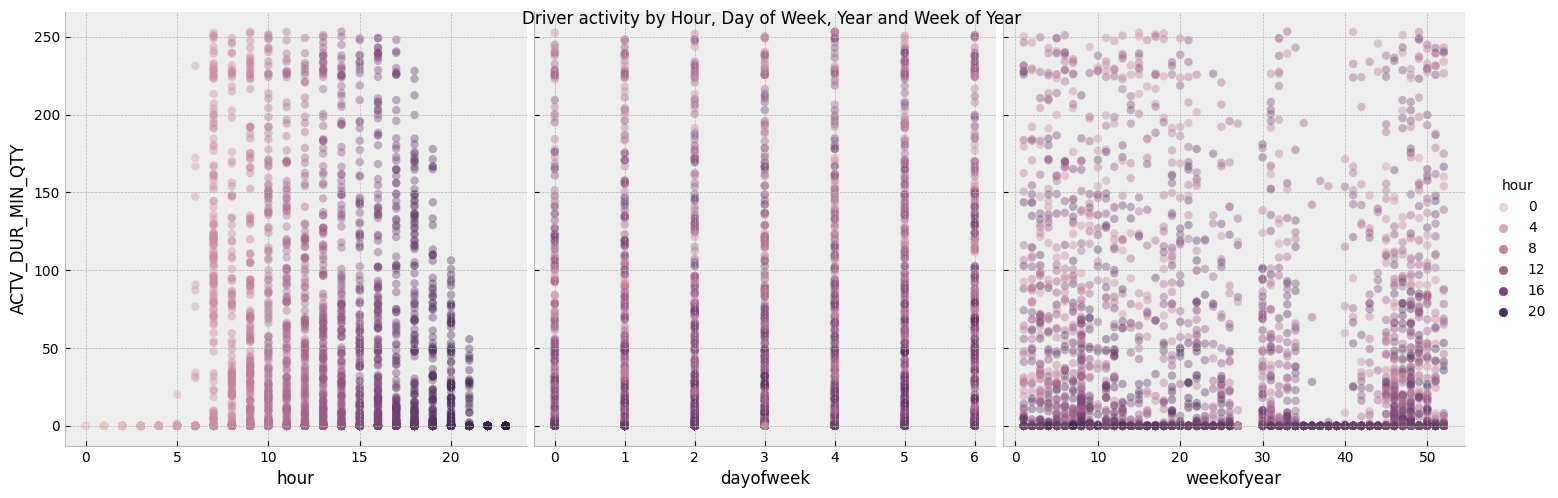

In [45]:
g = sns.pairplot(features_and_target,
             hue='hour',
             x_vars=['hour','dayofweek',
                     'weekofyear'],
             y_vars='ACTV_DUR_MIN_QTY',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )

plt.suptitle('Driver activity by Hour, Day of Week, Year and Week of Year')
plt.show()

In [46]:
def slot_calc(hour):
    
    if hour in range(6,11):
        return "morning"
    elif hour in range(11,17):
        return "afternoon"
    elif hour in range(17,23):
        return "evening"

In [47]:
features_and_target["slot"] = features_and_target["hour"].apply(slot_calc)
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ACTV_DUR_MIN_QTY,slot
dayhour,,,,,,,,,,
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.730000000,morning
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.730000000,morning
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.730000000,morning
2021-07-27 08:00:00,8,1,3,7,2021,208,27,30,0,morning
2021-07-27 09:00:00,9,1,3,7,2021,208,27,30,0,morning
...,...,...,...,...,...,...,...,...,...,...
2022-07-07 10:00:00,10,3,3,7,2022,188,7,27,10.100000000,morning
2022-07-07 10:00:00,10,3,3,7,2022,188,7,27,10.100000000,morning
2022-07-07 11:00:00,11,3,3,7,2022,188,7,27,194.320000000,afternoon


In [48]:
ft = features_and_target

In [49]:
ft["ACTV_DUR_MIN_QTY"] = pd.to_numeric(ft["ACTV_DUR_MIN_QTY"])
ft

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ACTV_DUR_MIN_QTY,slot
dayhour,,,,,,,,,,
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.73,morning
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.73,morning
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,47.73,morning
2021-07-27 08:00:00,8,1,3,7,2021,208,27,30,0.00,morning
2021-07-27 09:00:00,9,1,3,7,2021,208,27,30,0.00,morning
...,...,...,...,...,...,...,...,...,...,...
2022-07-07 10:00:00,10,3,3,7,2022,188,7,27,10.10,morning
2022-07-07 10:00:00,10,3,3,7,2022,188,7,27,10.10,morning
2022-07-07 11:00:00,11,3,3,7,2022,188,7,27,194.32,afternoon


# Data wrangling, exploration and stats

Plotting some graphs to get insights from the data.

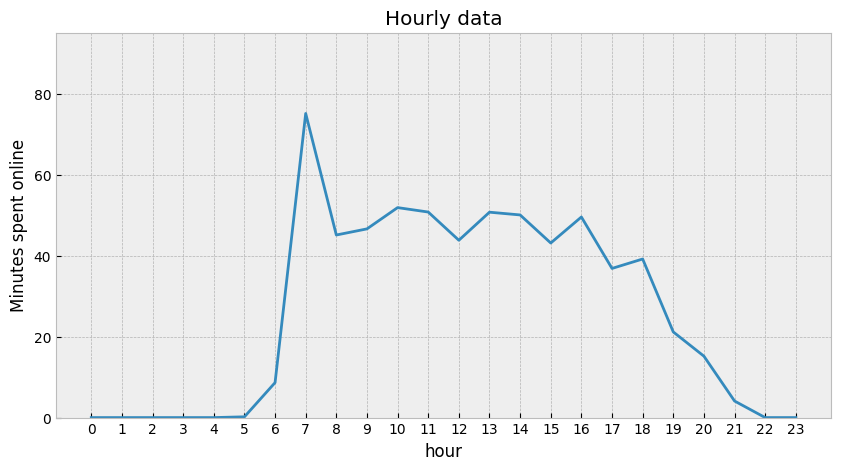

In [50]:
ft.groupby('hour')['ACTV_DUR_MIN_QTY'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(ft.groupby('hour')['ACTV_DUR_MIN_QTY'].mean() + 20 )])
_ = plt.xticks(ft['hour'].unique())
_ = plt.title('Hourly data')

- From the above average hourly online activity graph we can observe how the driver tends to turn on spark often during the day time and the activity gradually decreases towards night time.

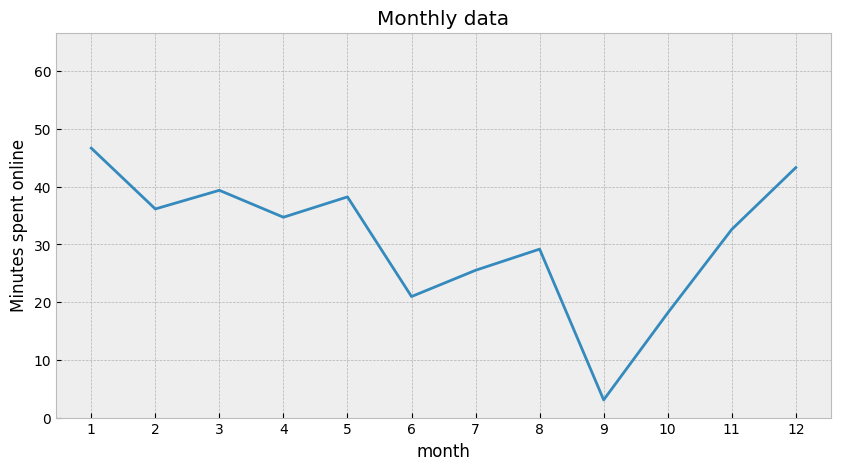

In [51]:
ft.groupby('month')['ACTV_DUR_MIN_QTY'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(ft.groupby('month')['ACTV_DUR_MIN_QTY'].mean() + 20 )])
_ = plt.xticks(ft['month'].unique())
_ = plt.title('Monthly data')

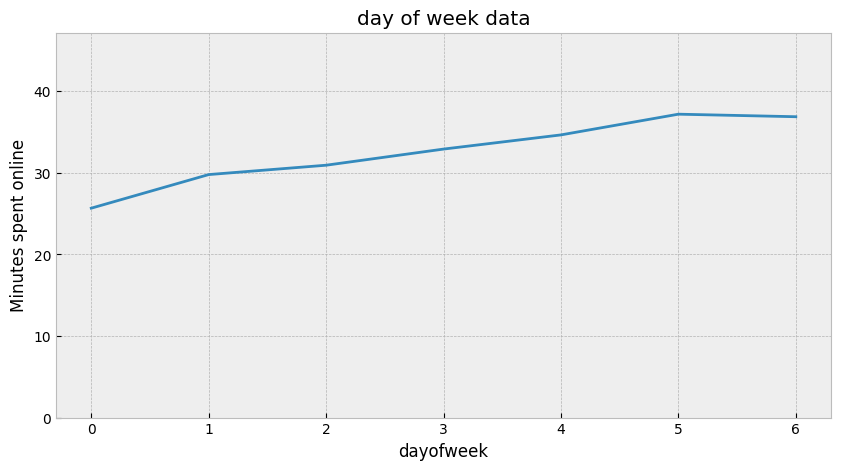

In [52]:
ft.groupby('dayofweek')['ACTV_DUR_MIN_QTY'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(ft.groupby('dayofweek')['ACTV_DUR_MIN_QTY'].mean() + 10 )])
_ = plt.xticks(ft['dayofweek'].unique())
_ = plt.title('day of week data')

In [53]:
hour_weekday = ft.pivot_table(values='ACTV_DUR_MIN_QTY', index='hour', columns = 'dayofweek', aggfunc = 'mean')

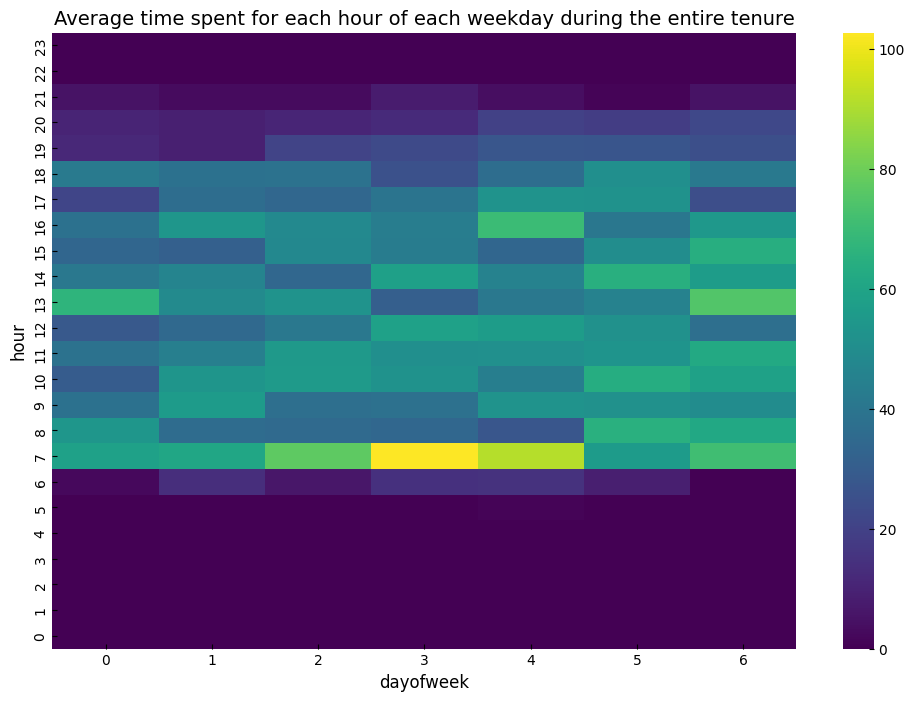

In [54]:
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
_ = ax.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

In [55]:
import pandas as pd

df = pd.read_csv(r'C:\Users\v0v01s7\Desktop\datatosend.csv')

'''Remove nulls'''

df['ACTV_START_TS'] = pd.to_datetime(df['ACTV_START_TS'])
df['ACTL_ACTV_END_TS'] = pd.to_datetime(df['ACTL_ACTV_END_TS'])
df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60

df = df[df['minutes']>0].reset_index(drop=True)

# create an IntervalIndex which we can set as the axis (needed for re-indexing).
# subtract one minute from end_time so that the minute of the termination is excluded.
iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                      df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                      closed='both')

# create a new index with the extended frequency:
new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')

# set the new index to get the extended frequency;
# all minutes will have the value of the whole interval
result = df['minutes'].set_axis(iv_idx).reindex(new_idx)

# we can now calculate the duration per hour by resampling and summing the
# boolean representation of the duration (1/0):
result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
result.index.name = 'start_hour'

In [56]:
re = pd.DataFrame(result)
re

,minutes
start_hour,
2021-07-27 07:00:00,13
2021-07-27 08:00:00,35
2021-07-27 09:00:00,0
2021-07-27 10:00:00,44
2021-07-27 11:00:00,60
...,...
2022-07-06 12:00:00,0
2022-07-06 13:00:00,0
2022-07-06 14:00:00,51


In [58]:
re.head()

,minutes
start_hour,
2021-07-27 07:00:00,13
2021-07-27 08:00:00,35
2021-07-27 09:00:00,0
2021-07-27 10:00:00,44
2021-07-27 11:00:00,60


In [59]:
X, y = create_features(re, label='minutes')

features_and_target = pd.concat([X, y], axis=1)

C:\Users\V0V01S7\AppData\Local\Temp\ipykernel_8864\528181612.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [60]:
fe = features_and_target
fe

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes
start_hour,,,,,,,,,
2021-07-27 07:00:00,7,1,3,7,2021,208,27,30,13
2021-07-27 08:00:00,8,1,3,7,2021,208,27,30,35
2021-07-27 09:00:00,9,1,3,7,2021,208,27,30,0
2021-07-27 10:00:00,10,1,3,7,2021,208,27,30,44
2021-07-27 11:00:00,11,1,3,7,2021,208,27,30,60
...,...,...,...,...,...,...,...,...,...
2022-07-06 12:00:00,12,2,3,7,2022,187,6,27,0
2022-07-06 13:00:00,13,2,3,7,2022,187,6,27,0
2022-07-06 14:00:00,14,2,3,7,2022,187,6,27,51


In [61]:
month_dict = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}
day_dict = {0:"Monday",0:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
#fe = fe.replace({"dayofweek":day_dict})
#fe = fe.replace({"month":month_dict})

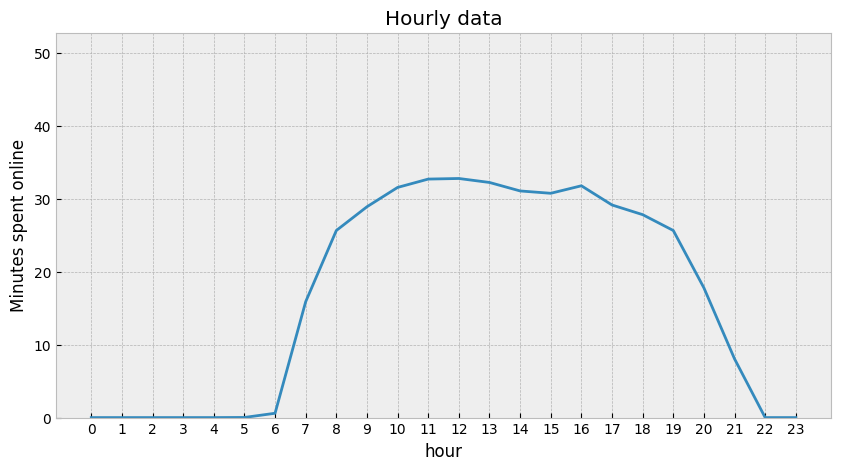

In [62]:
fe.groupby('hour')['minutes'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(fe.groupby('hour')['minutes'].mean() + 20 )])
_ = plt.xticks(fe['hour'].unique())
_ = plt.title('Hourly data')

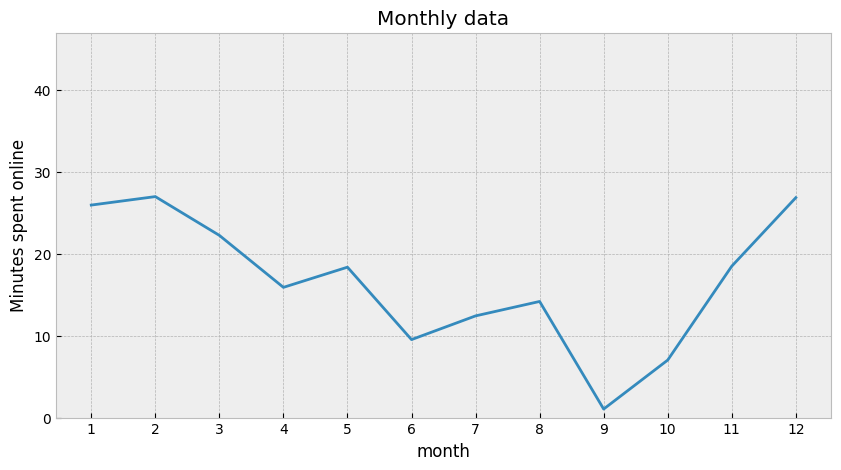

In [63]:
fe.groupby('month')['minutes'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(fe.groupby('month')['minutes'].mean() + 20 )])
_ = plt.xticks(fe['month'].unique())
_ = plt.title('Monthly data')

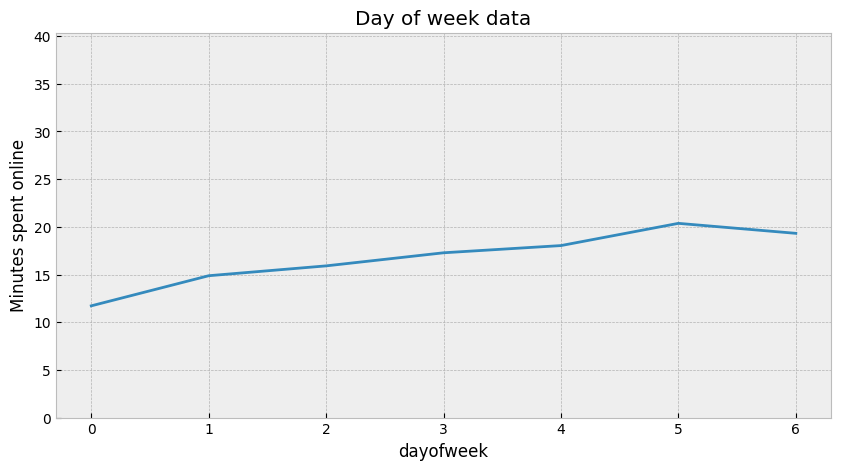

In [64]:
fe.groupby('dayofweek')['minutes'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Minutes spent online')
_ = plt.ylim([0, max(fe.groupby('dayofweek')['minutes'].mean() + 20 )])
_ = plt.xticks(fe['dayofweek'].unique())
_ = plt.title('Day of week data')

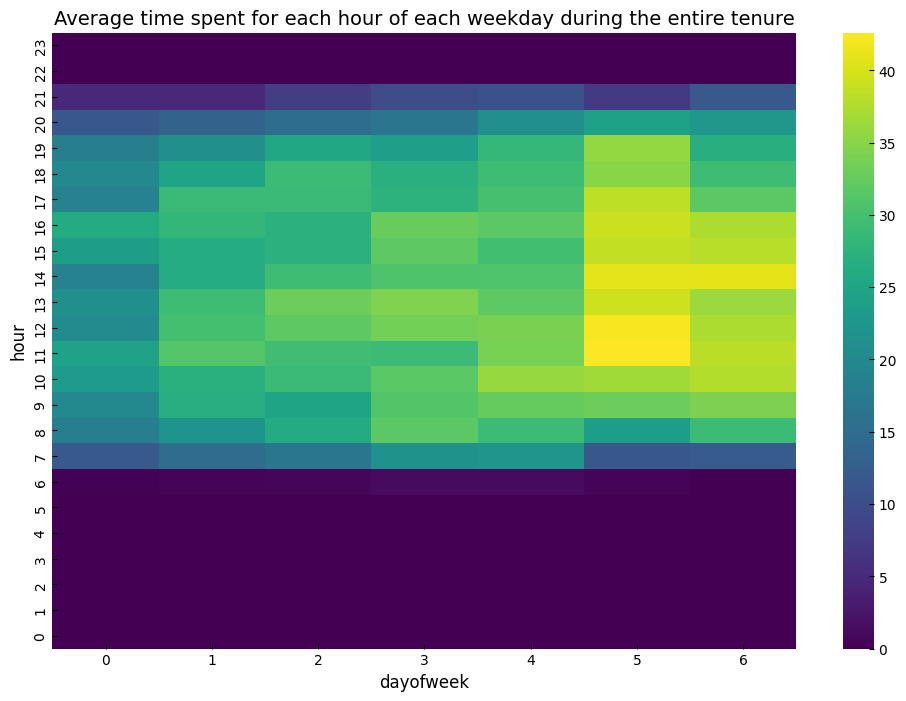

In [65]:
hour_weekday = fe.pivot_table(values='minutes', index='hour', columns = 'dayofweek', aggfunc = 'mean')
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
_ = ax.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

C:\Users\V0V01S7\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


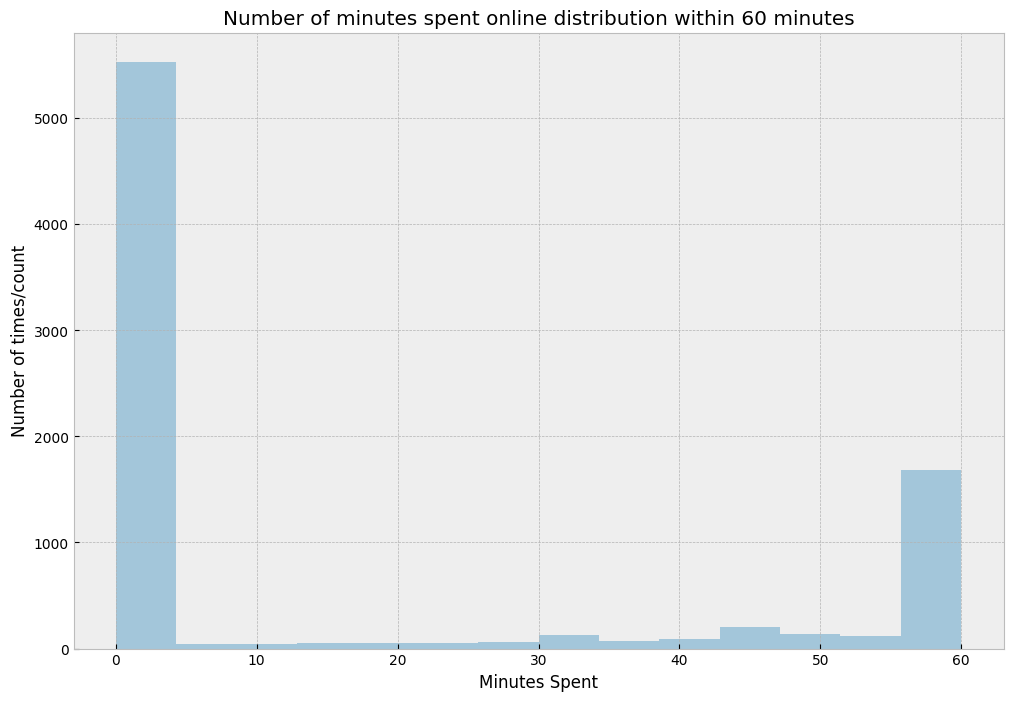

In [66]:
_ = plt.figure(figsize = (12,8))
_ = sns.distplot(fe['minutes'], kde=False)
_ = plt.title('Number of minutes spent online distribution within 60 minutes')
_ = plt.xlabel('Minutes Spent')
_ = plt.ylabel('Number of times/count')

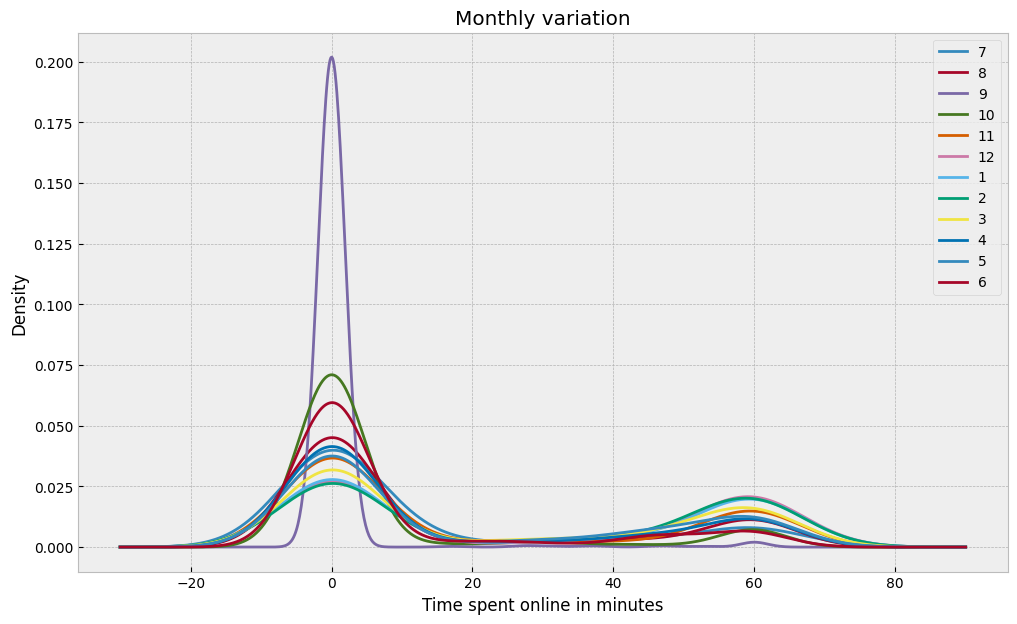

In [67]:
for month in fe['month'].unique():
    fe[fe['month'] == month]['minutes'].plot(kind='density', figsize = (12,7), legend = True, label = month)
_ = plt.xlabel('Time spent online in minutes')
_ = plt.title('Monthly variation')

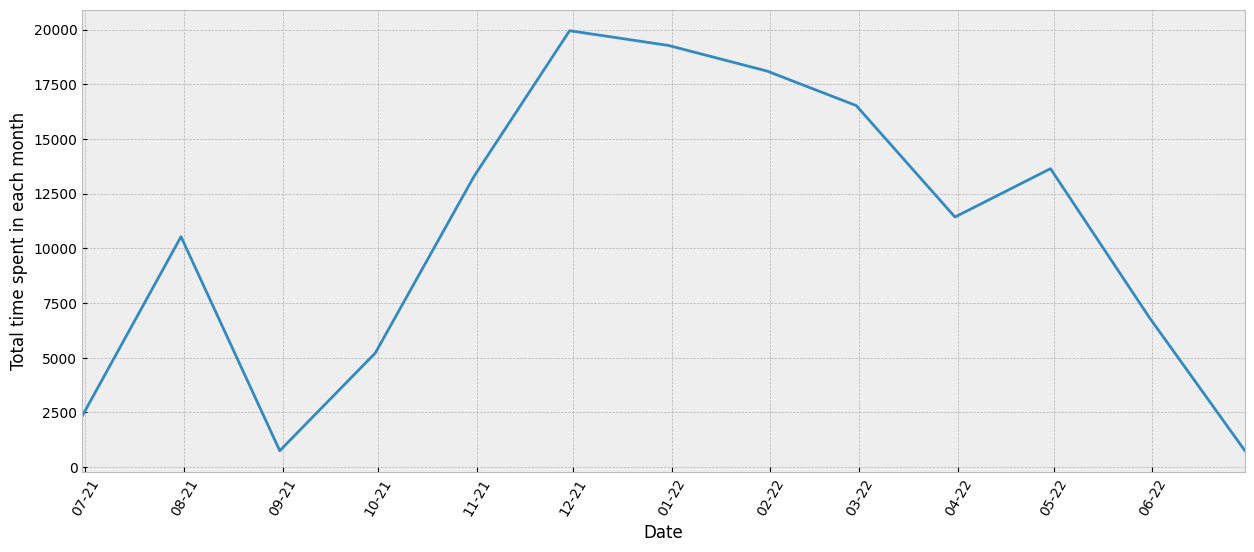

In [68]:
monthly_en = fe.resample('M', label = 'left')['minutes'].sum()
_ = plt.figure(figsize = (15,6))
_ = plt.plot(monthly_en)
_ = plt.xlim(monthly_en.index.min(), monthly_en.index.max())
locator = mdates.MonthLocator(bymonthday = 1, interval = 1)  # every month
fmt = mdates.DateFormatter('%m-%y')  # xticks to be displayed as 01-14 (i.e. Jan'14) and so on
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
_ = plt.xticks(rotation = 60)
_ = plt.ylabel('Total time spent in each month')
_ = plt.xlabel('Date')
